# DLfsP LSTM Autoencoder am Beispiel zyklischer Prozessdaten
Kurs Deep Learning für sequentielle Prozessdaten

#### In diesem Notebook wird ein LSTM Autoencoder auf Zeitreihendaten eines zyklischen Prozesses angewendet. 

Die Daten stammen von einer echten Produktionsanlage mussten jedoch für die Verwendung hier anonymisiert werden. Beim Prozess handelt es sich um einen zyklischen Prozess, wobei ein Zyklus, hier Takt genannt, etwa 2,7 Sekunden dauert. Der Prozesszyklus soll anhand des Motorstroms des Hauptantriebes überwacht werden. Dazu wurden einige anomale Zyklen bereitgestellt, diese dienen zur Entwicklung Anomaliedetektion.

Ziel der Aufgabe ist somit, einen LSTM Autoencoder zu entwickeln, der den Prozessverlauf von guten Zyklen erlernt hat.  
Darauf aufbauend soll eine Anomaliedetektion entworfen werden. 

__Hinweis:__ Auch wenn die Aufgabe LSTM Autoencoder heißt, dürfen auch andere rekurrente Schichten wie GRU verwendet werden. 


### Data-Mining-Prozess:
![Daten erfassen -> Daten erkunden -> Daten vorbereiten -> Modelle bilden -> Modelle validieren -> Modell testen & anwenden](Prozess_Modellentwicklung_v2.png "model development")

## 0. Bibliotheken importieren

In [1]:
"""import libraries"""
import numpy as np
import pandas as pd
import random
from random import randint
import os

import tensorflow as tf
from tensorflow.keras import Sequential

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_recall_curve
import seaborn as sns

#Einstellungen für die Grafikausgabe
style = 'seaborn-whitegrid'
plt.style.use(style)
plt.rcParams.update({'font.size': 14})  # Schriftgröße aller Textzeichen im Graphen

In [31]:
# use TF with GPU or CPU ?
print('\nTF version: ' + tf.__version__)
if tf.test.is_built_with_gpu_support():
    if len(tf.config.list_physical_devices('GPU'))==0:
         print('Please install GPU version of TF\n' +
                  'TF is currently using the CPU')
    else:
        print('Default GPU Device: {}'.format(tf.config.list_physical_devices('GPU')))
        # GPU-Memory-Management:
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        session = tf.compat.v1.Session(config=config)
else:
    print('TF CPU version active')


TF version: 2.6.0
Default GPU Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


TODO:
* Wähle eine Zahl zwischen 1 und 100 für die Generierung deiner spezifischen Zufallszahlen my_seed=

Damit Ergebnisse Reproduzierbar sind, müssen mehrere Seeds für Zufallszahlengeneratoren gesetzt werden. 

AUSGABE:
* Gewählte Zufallszahl

In [32]:
''' Setzen von Seeds, um Reproduzierbarkeit zu ermöglichen. '''
# Erstelle eigene Zufallszahlen
my_seed = TODO

# Ausgabe gewählte Zufallszahlen
print("\nGewählte Zahl für Zufallszahlen: \t" + str(my_seed))

# Seeds für diverse Zufallszahlengeneratoren setzen 
os.environ['PYTHONHASHSEED']=str(my_seed)
tf.random.set_seed(my_seed)
random.seed(my_seed)
np.random.seed(my_seed)


Gewählte Zahl für Zufallszahlen: 	2


## 1. Daten erfassen
Bei den Daten handelt es sich wieder um CSV Dateien. Diese wurden jedoch aus Effizienzgründen gezippt.   
Jedoch ist Pandas in der Lage, direkt die Daten aus den gezippten Dateien zu importieren.   
Dazu ist der Zusatzbefehl "compression='zip'" notwendig.

In [33]:
''' Daten importieren'''
df = pd.read_csv('zykl_Produktionsprozess_gut.zip', compression='zip') 
df_anomaly = pd.read_csv('zykl_Produktionsprozess_anomal.zip', compression='zip') 
print('Daten erfolgreich importiert')

Daten erfolgreich importiert


## 2. Daten erkunden

In [34]:
""" ersten Datensätze als Beispiel"""
df.head(5)

,Takt,Status,Motorstrom,time_ms
0,1003.0,0.0,0.554150,10
1,1003.0,0.0,0.384974,20
2,1003.0,0.0,0.488325,30
3,1003.0,0.0,0.431701,40
4,1003.0,0.0,0.514161,50


In [35]:
""" Statistische Beschreibung Datensatz"""
df.describe()

,Takt,Status,Motorstrom,time_ms
count,275724.000000,275724.0,275724.000000,275724.000000
mean,1502.000000,0.0,0.534310,1385.000000
std,288.386838,0.0,0.130107,796.739587
min,1003.000000,0.0,0.107698,10.000000
25%,1252.000000,0.0,0.452138,697.500000
50%,1502.000000,0.0,0.514477,1385.000000
75%,1752.000000,0.0,0.611305,2072.500000
max,2001.000000,0.0,1.000000,2760.000000


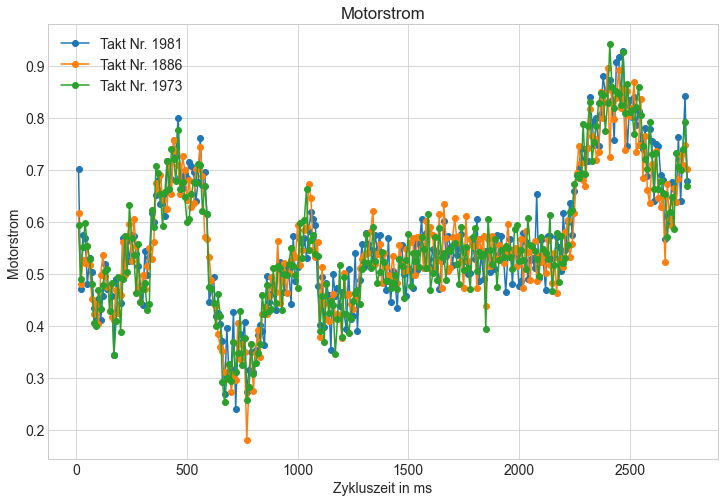

In [36]:
""" Zyklen plotten. """
# Auswahl zufälliger Zyklen 
cycles = random.sample(df['Takt'].drop_duplicates().to_list(), 3)

plt.figure(figsize=(12,8))
plt.title('Motorstrom')
for c in cycles:
    plt.plot(df[df['Takt']==c]['time_ms'],df[df['Takt']==c]['Motorstrom'],'o-',label='Takt Nr. '+str(int(c)))

plt.ylabel('Motorstrom')
plt.xlabel('Zykluszeit in ms')
plt.legend()
plt.show()

## 3. Daten vorbereiten

In [37]:
""" Aufteilung in X und y"""
# Maximale Zykluslänge
maxlen = df['Takt'].value_counts().max()    
print(maxlen)

# Aufteilung X und y Daten als DataFrames
# Daten ohne Anomalien
y_df = df[['Status','Takt']]
X_df = df.reset_index(drop=True)
# Anomalien
y_df_anomaly = df_anomaly[['Status','Takt']]
X_df_anomaly = df_anomaly.reset_index(drop=True)

276


In [38]:
""" Umwandeln der DataFrames in numpy arrays und group by run_ID"""
# Daten ohne Anomalien
g = X_df.groupby('Takt').cumcount()
X = (X_df.set_index(['Takt',g])
     .unstack()
     .stack().groupby(level=0)
     .apply(lambda x: x['Motorstrom'].values)
     .to_numpy())
g = y_df.groupby('Takt').cumcount()
y = (y_df.set_index(['Takt',g])
     .unstack()
     .stack().groupby(level=0)
     .apply(lambda x: np.rint(x.sum()/len(x)))
     .to_numpy().astype("int32"))

print('Shapes der numpy Arrays X und y:')
print(X.shape, y.shape)

# Anomalien
g = X_df_anomaly.groupby('Takt').cumcount()
X_anomaly = (X_df_anomaly.set_index(['Takt',g])
     .unstack()
     .stack().groupby(level=0)
     .apply(lambda x: x['Motorstrom'].values)
     .to_numpy())
g = y_df_anomaly.groupby('Takt').cumcount()
y_anomaly = (y_df_anomaly.set_index(['Takt',g])
     .unstack()
     .stack().groupby(level=0)
     .apply(lambda x: np.rint(x.sum()/len(x)))
     .to_numpy().astype("int32"))

print('Shapes der numpy Arrays X_anomaly und y_anomaly:')
print(X_anomaly.shape, y_anomaly.shape)

Shapes der numpy Arrays X und y:
(999,) (999, 1)
Shapes der numpy Arrays X_anomaly und y_anomaly:
(176,) (176, 1)


In [39]:
'''Auffüllen der ungleichen Messreihen'''
# Auffüllen mit führenden Nullen, damit die Zeitreihen die gleiche Länge haben
X_pre = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=maxlen, padding='pre', dtype="float32")
X_anomaly_pre = tf.keras.preprocessing.sequence.pad_sequences(X_anomaly, maxlen=maxlen, padding='pre', dtype="float32")

In [40]:
'''Aufteilen in Trainings-und Testdaten'''
# Hinweis: Für die Validierung wird dieses Mal eine direkte Variante von Tensorflow verwendet
# Festlegen des Anteils an Testdaten 
test_split = 0.2

# Aufteilung der Daten
# Testdaten abspalten# Aufteilung der Daten
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, 
                                                    test_size=test_split, 
                                                    shuffle=True, 
                                                    random_state=my_seed)
# Kombinieren der Testdaten und Anomaliedaten zu einem Datensatz für die Anomaliedetektion (AD)
X_AD = np.concatenate((X_test, X_anomaly_pre), axis=0)
y_AD = np.concatenate((y_test, y_anomaly))

nr_train=len(X_train)
nr_AD=len(X_AD)
print(nr_train, "Training sequences")
print(nr_AD, "Anomaliedetektion sequences")

799 Training sequences
376 Anomaliedetektion sequences


In [41]:
'''Formatierung der Daten'''
X_train = X_train.reshape(nr_train, maxlen, 1)
X_AD = X_AD.reshape(nr_AD, maxlen, 1)

In [42]:
''' Überprüfen der Form der Numpy Arrays. '''
print('Shape X_train:\t' + str(X_train.shape))
print('Shape X_AD:\t' + str(X_AD.shape))

Shape X_train:	(799, 276, 1)
Shape X_AD:	(376, 276, 1)


## 4. Modelle bilden

### 1.) Modellaufbau des LSTM Autoencoders

Erstelle ein Decoder-Encoder Modell das als Autoencoder verwendet werden soll. 

TODO:
* Importiere den notwendigen Layer
* Definiere eine Modellstruktur 
* Die Anzahl der Layer und die Anzahl der Knoten/Nodes pro Layer ist einem selbst überlassen 
* Probiere also verschiedene Modellgrößen aus, um das beste Modell für die Aufgabe zu finde

__Hinweis:__  
* Anstatt LSTM Schichten kann auch gerne eine GRU Schicht verwendet werden

In [43]:
'''Modellaufbau'''
# Import der notwendigen Schichten
TODO

# Definition des Input_Shapes
input_shape = TODO

# Definition des Modells
model=Sequential()
"""
*
* TODO: 
*      Layers hinzufügen
*     
"""

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 276, 64)           16896     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                12416     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 276, 32)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 276, 32)           8320      
_________________________________________________________________
lstm_11 (LSTM)               (None, 276, 64)           24832     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 276, 1)            65        
Total params: 62,529
Trainable params: 62,529
Non-trainable params: 0
__________________________________________________

### 2.) Modellkompilierung des LSTM Autoencoder Modells
TODO: 
* Wähle einen Optimierer aus (Adam, Nadam, RMSprop oder SGD) 
* Lege - falls notwendig - die Parameter des Optimiers fest, Lernrate, GradientClipping o.ä.
* Bestimme, welche Loss Funktion verwendet werden soll 

Hinweise:  
Die Lernrate ist ein sehr wichtiger Hyperparameter, der viel Einfluss auf den Verlauf und Schnelligkeit des Trainings hat!

In [44]:
''' Modell kompilieren. '''
# Optimizer festlegen
optimizer = TODO

# Einstellung für das spätere Training zum Kompilieren festlegen
model.compile(TODO)

### 3.) Trainieren des LSTM Autoencoder Modells

TODO:
* Wähle die Anzahl der Epochen aus, für die das Modell trainiert werden soll  
* Danach müssen die Trainingsinputs, -outputs sowie die Validierungsdaten bestimmt werden  
* Anstatt Tensorflow die Validierungsdaten zu geben, soll dies Tensorflow selbstständig machen. Stelle dazu den validation_split auf einen geeigneten Wert (z.B.  0.1)

Hinweis:  
* Nicht vergessen, die Zielgröße beim Autoencoder ist nicht der Status, der in "y_train" abgespeichert worden ist, sondern die Rekonstruktion von X_train. 

Ausgabe: 
* Zwischenergebnisse je Epoche

In [ ]:
''' Modell trainieren '''
# Festlegung der Batch_Size und Anzahl der Epoche
epochs = TODO
batch_size = TODO

history = model.fit(TODO)

Epoch 1/100


# 5. Modelle validieren

## Visualisierung der Ergebnisse

In [ ]:
""" Trainingsverlauf plotten. """
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss) +1)

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, 'b-x', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlim((0, max(epochs)))
plt.ylim(bottom=0.0)  
plt.xlabel('Epochs')
plt.title('Training loss Autoencoder Model')
plt.legend()

plt.show()

## Vergleich Vorhersage vs. echter Verlauf

In [ ]:
''' Plotten echter Zyklus und vorhergesaten Zyklus'''
plt.figure(figsize=(12,8))
plt.plot(X_train[1,:,:], label='Original Zyklus')
plt.plot(model.predict(X_train)[1], label='Vorhersage')
plt.xlabel('Zeit in ms')
plt.ylabel('Motorstrom')
plt.title('Vorhersage vs. echter Verlauf')
plt.legend()

plt.show()

## Retrain Autoencoder

Nach dem finden der besten Hyperparameter für das Autoencoder Modell ist es sinnvoll, diesen nochmal mit allen Daten (Training und Validierung) zu trainieren. Dies sollte die folgenden Ergebnisse nochmal verbessern. 
Hiwer wird aber aus Zeitgründen darauf verzichtet.

# Anomaliedetektion

Führe diesen Schritt erst aus, wenn das erstellt Modell gut genug performt.

Bei der Anomaliedetektion soll der LSTM Autoencoder verwendet werden, um Anomalien vorhzusagen. Dafür muss ein Rekonstruktionsfehler ausgewählt werden und ein Threshold für den Rekonstruktionsfehler bestimmt werden.   
Zur Hilfe wird hier die Precision Recall Kurve für verschiedene Thresholds geplottet und die Verteilung der Fehler geplottet. 

TODO: 
* Wähle einen Rekonstruktionsfehler aus den zwei vorgegebenen, die mittlere absolute Abweichung oder die maximale absolute Abweichung
* Bestimme einen Threshold

In [ ]:
''' Histogramm der Fehler für Trainingsdaten'''
# Berechnung der Vorhersagen für die Trainingsdaten
X_train_pred = model.predict(X_train)

# Berechnung der Rekonstruktionsfehler (zwei Varianten)
train_max_abs_error = np.max(np.abs(X_train_pred - X_train),axis=1).flatten()
train_mean_abs_error = np.mean(np.abs(X_train_pred - X_train),axis=1).flatten()

# Auswahl bzw. Übergabe eines Rekonstruktionsfehlers
train_error = TODO

# Plot Verteilung der Rekonstruktionsfehler
plt.figure(figsize=(9,6))
plt.hist(train_error, bins=50)
plt.xlabel("Train Rekonstruktionsfehler")
plt.ylabel("Häufigkeit")
plt.show()

In [ ]:
''' Erstellung einer Precision Recall Kurve '''
# Vorhersage der Verläufe für den X_AD Datensatz
X_AD_pred = model.predict(X_AD)

max_abs_error = np.max(np.abs(X_AD_pred - X_AD),axis=1).flatten()
mean_abs_error = np.mean(np.abs(X_AD_pred - X_AD),axis=1).flatten()

AD_error = TODO
error_df = pd.DataFrame({'reconstruction_error':AD_error,
                        'True_class':y_AD.flatten().tolist()})

print(error_df.head(5))

precision, recall, threshold = precision_recall_curve(error_df.True_class, error_df.reconstruction_error)

plt.figure(figsize=(12,8))
plt.title('Precision and Recall for different threshold values')
plt.plot(threshold, precision[1:],label="Precision")
plt.plot(threshold, recall[1:],label="Recall")
plt.xlim(left=0.0) 
plt.ylim(0.0,1.01)
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()


In [ ]:
''' Auswahl eines Thresholds '''
# Der threshold (dt. Grenzwert) bestimmt, ab welchen Fehlergröße ein Verlauf als Anomalie eingestuft wird
threshold = TODO
print("Reconstruction error threshold:", threshold)

In [ ]:
"""Anomaliedetektion bewerten """
# Plot Verteilung aller Rekonstruktionsfehlerwerte
plt.figure(figsize=(9,6))
plt.hist(AD_error, bins=50)
plt.xlabel("AD Rekonstruktionsfehler")
plt.ylabel("Häufigkeit")
plt.show()

# Bestimmung der vorhergesagten Anomalien
y_AD_pred = (AD_error > threshold).astype("int32")

# Berechne Genauigkeit auf den Anomaliedetektionsdaten
accuracy_test = accuracy_score(y_AD, y_AD_pred)

# Berechne den F1-Score auf den Anomaliedetektionsdaten
f1score_test = f1_score(y_AD, y_AD_pred)

# Ausgabe der Modellgenauigkeit
print('Ergebnis für den Test:')
print('Accuracy: \t' + str(round(accuracy_test, 4)))
print('F1-Score: \t' + str(round(f1score_test, 4)))

# Visualisierung der Konfusionsmatrix
ConfusionMatrixDisplay.from_predictions(y_AD, y_AD_pred)
plt.grid()
plt.title('Konfusionsmatrix auf Testdaten')
plt.show()

# Classification Report
print('Classification Report')
print(classification_report(y_AD, y_AD_pred))